Data Preparation: 100%|██████████| 3/3 [00:57<00:00, 19.09s/it]


Starting training from scratch.


Epoch:   1%|          | 99/10000 [56:29<98:56:46, 35.98s/it] 

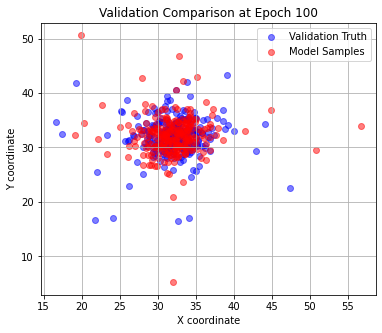

Epoch:   2%|▏         | 199/10000 [1:55:45<121:04:34, 44.47s/it]

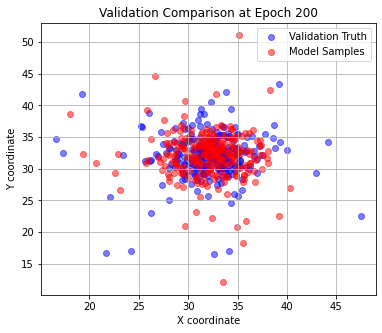

Epoch:   3%|▎         | 299/10000 [2:54:08<80:57:22, 30.04s/it] 

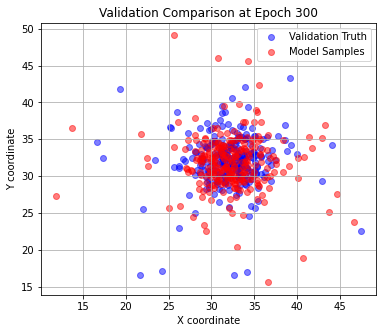

Epoch:   4%|▍         | 399/10000 [4:03:49<79:06:12, 29.66s/it] 

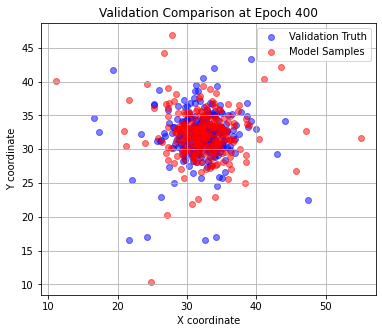

Epoch:   5%|▍         | 499/10000 [5:12:06<118:12:18, 44.79s/it]

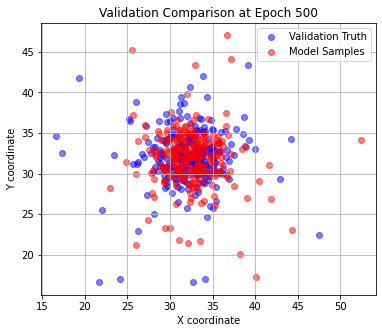

Epoch:   6%|▌         | 599/10000 [6:28:06<112:40:54, 43.15s/it]

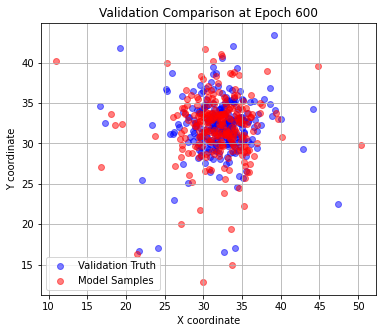

Epoch:   7%|▋         | 699/10000 [7:43:45<112:01:43, 43.36s/it]

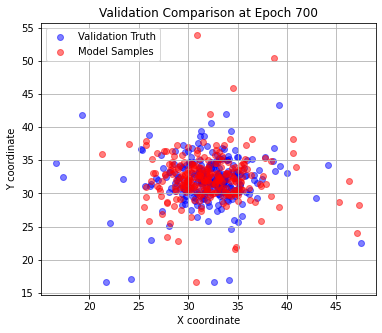

Epoch:   8%|▊         | 799/10000 [8:59:03<117:51:47, 46.12s/it]

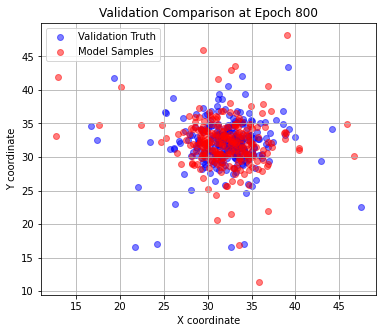

Epoch:   9%|▉         | 899/10000 [10:15:27<112:19:10, 44.43s/it]

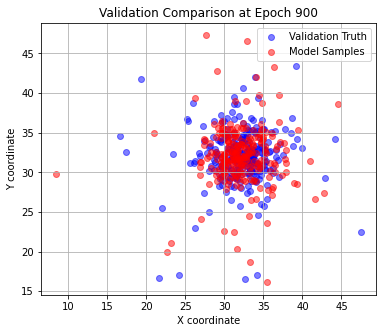

Epoch:  10%|▉         | 999/10000 [11:31:31<115:17:46, 46.11s/it]

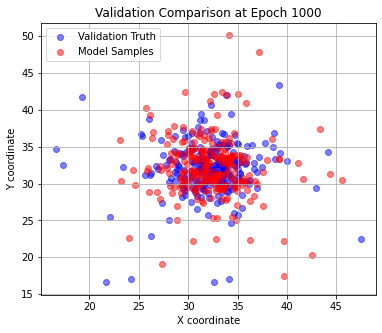

Epoch:  11%|█         | 1099/10000 [12:47:47<121:43:13, 49.23s/it]

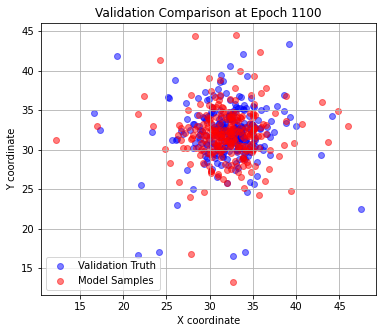

Epoch:  12%|█▏        | 1199/10000 [14:04:28<114:09:33, 46.70s/it]

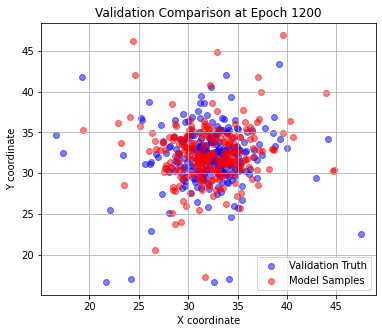

Epoch:  13%|█▎        | 1299/10000 [15:33:51<128:40:12, 53.24s/it]

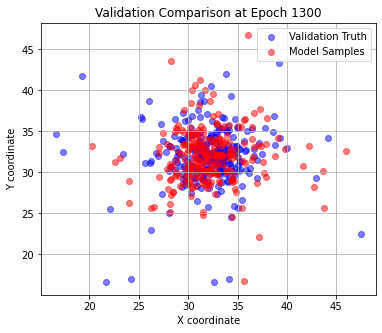

Epoch:  14%|█▍        | 1399/10000 [17:43:49<130:09:55, 54.48s/it]  

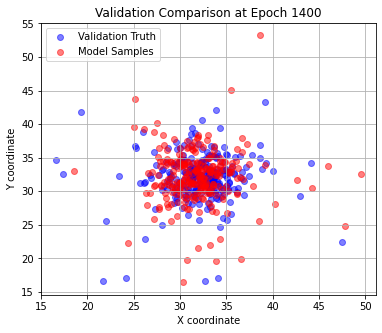

Epoch:  15%|█▍        | 1499/10000 [19:18:41<113:31:38, 48.08s/it] 

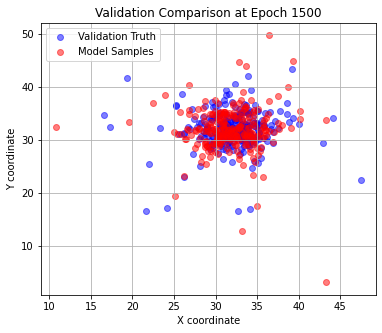

Epoch:  16%|█▌        | 1599/10000 [21:41:45<110:52:41, 47.51s/it]  

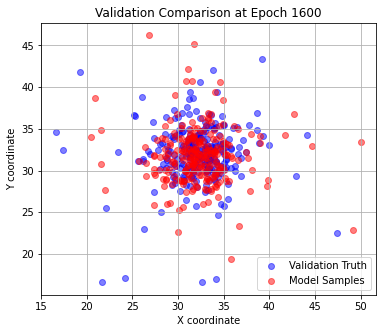

Epoch:  17%|█▋        | 1699/10000 [22:58:12<109:55:30, 47.67s/it]

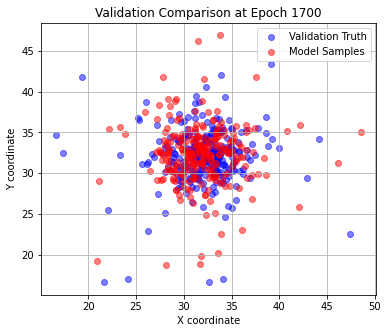

Epoch:  18%|█▊        | 1799/10000 [26:35:07<93:53:07, 41.21s/it]    

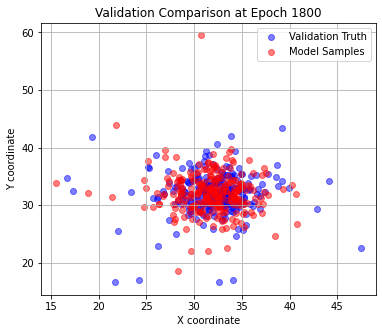

Epoch:  19%|█▉        | 1899/10000 [27:49:49<115:38:25, 51.39s/it]

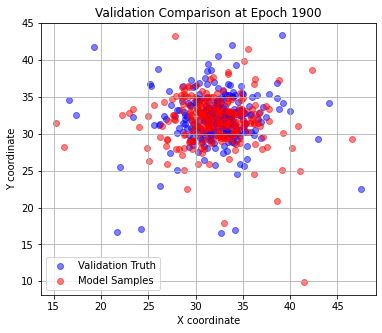

Epoch:  20%|█▉        | 1999/10000 [29:03:35<97:39:04, 43.94s/it] 

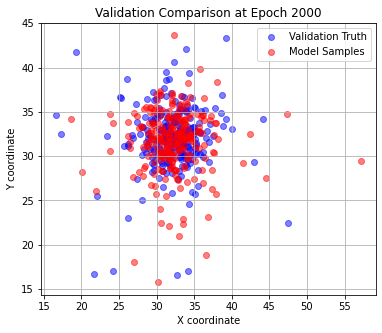

Epoch:  21%|██        | 2099/10000 [30:16:39<94:18:30, 42.97s/it] 

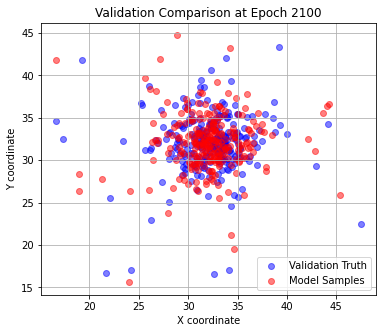

Epoch:  22%|██▏       | 2199/10000 [31:32:10<90:26:50, 41.74s/it] 

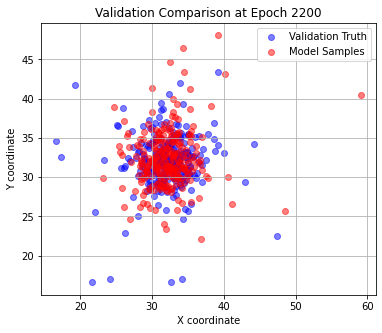

Epoch:  23%|██▎       | 2299/10000 [32:45:56<95:14:52, 44.53s/it] 

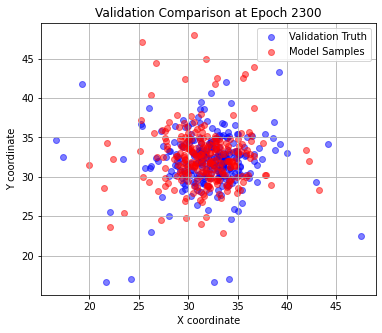

Epoch:  24%|██▍       | 2399/10000 [34:00:03<90:23:55, 42.81s/it] 

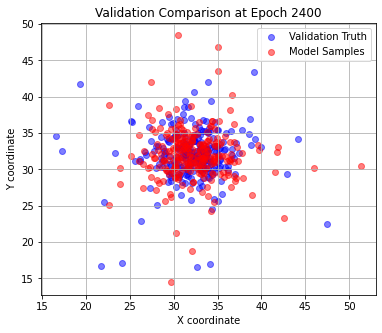

Epoch:  25%|██▍       | 2499/10000 [35:14:28<93:37:52, 44.94s/it] 

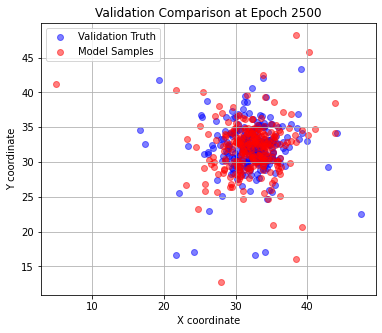

Epoch:  26%|██▌       | 2599/10000 [36:28:38<93:47:05, 45.62s/it] 

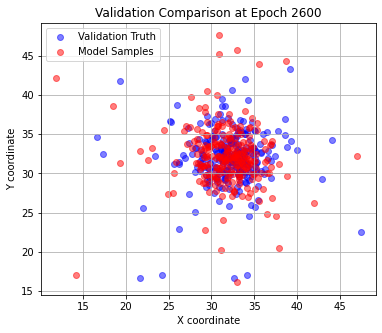

Epoch:  27%|██▋       | 2699/10000 [37:42:27<93:29:32, 46.10s/it] 

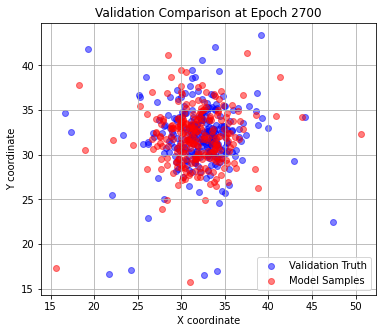

Epoch:  28%|██▊       | 2799/10000 [39:01:31<91:06:06, 45.54s/it] 

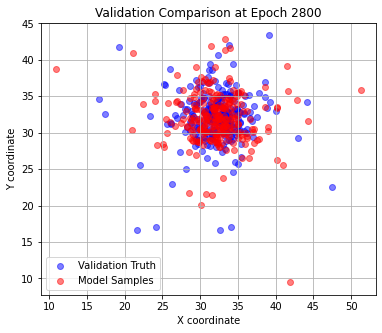

Epoch:  29%|██▉       | 2899/10000 [40:20:36<85:07:18, 43.15s/it] 

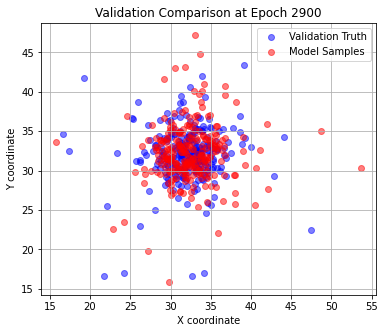

Epoch:  30%|██▉       | 2999/10000 [43:11:20<91:58:55, 47.30s/it]    

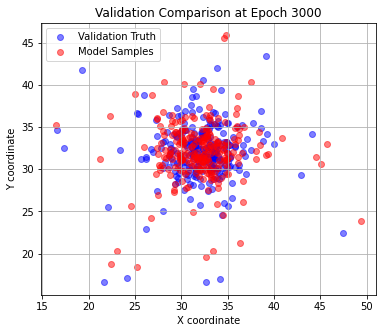

Epoch:  31%|███       | 3099/10000 [45:19:58<166:57:15, 87.09s/it] 

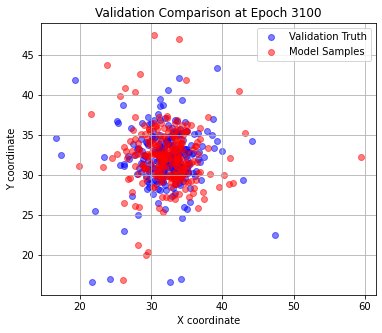

Epoch:  32%|███▏      | 3169/10000 [46:36:35<100:28:15, 52.95s/it] 


KeyboardInterrupt: 

In [3]:
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy.ndimage import gaussian_filter
from scipy.interpolate import RegularGridInterpolator
import glob

from itertools import product

###################################
#Hyperparameters (FEEL FREE TO ADJUST)
###################################

num_samples_per_bubble = 1000
num_points_per_bubble = 24
num_rays_per_point = 6
num_samples_per_point = num_samples_per_bubble // num_points_per_bubble

batch_size = 256
nr_epochs = 1000
dim = 2 # (X,Y)

cond_dim = 2 + num_rays_per_point + 1  # (2 for center, 6 for rays, 1 for mass)
layers_count = 6
checkpoint_path = "SETCHECKPOINTPATH.pth"

###################################
#Base Distribution
###################################
class BaseDistribution(nn.Module):
    def __init__(self, mean=torch.tensor([0.0, 0.0]), std=torch.tensor([1.0, 1.0])):
        super().__init__()
        self.dist = torch.distributions.MultivariateNormal(
            loc=mean, covariance_matrix=torch.diag(std**2)
        )

    def sample(self, num_samples):
        return self.dist.sample((num_samples,))

    def log_prob(self, x):
        return self.dist.log_prob(x)

###################################
#GLOW Components (ActNorm + Invertible 1x1 Conv + AffineCoupling)
###################################
class ActNorm(nn.Module):
    def __init__(self, dim, init=True):
        super().__init__()
        self.dim = dim
        self.initialized = (not init)
        self.bias = nn.Parameter(torch.zeros(dim))
        self.log_scale = nn.Parameter(torch.zeros(dim))

    def initialize_params(self, x):
        with torch.no_grad():
            mean = x.mean(dim=0)
            std = x.std(dim=0)
            self.bias.data = -mean
            self.log_scale.data = torch.log(1.0 / (std + 1e-6))
        self.initialized = True

    def forward(self, x, cond=None):
        if not self.initialized:
            self.initialize_params(x)
        y = (x + self.bias) * torch.exp(self.log_scale)
        log_det = self.log_scale.sum().expand_as(x[:, 0])
        return y, log_det

    def inverse(self, y, cond=None):
        x = y * torch.exp(-self.log_scale) - self.bias
        log_det = -self.log_scale.sum().expand_as(y[:, 0])
        return x, log_det

class Invertible1x1Conv(nn.Module):
    def __init__(self, dim):
        super().__init__()
        w_init = torch.qr(torch.randn(dim, dim))[0]
        self.weight = nn.Parameter(w_init)
        self.dim = dim

    def forward(self, x, cond=None):
        y = x @ self.weight
        log_det = torch.logdet(self.weight).expand_as(x[:, 0])
        return y, log_det

    def inverse(self, y, cond=None):
        W_inv = torch.inverse(self.weight)
        x = y @ W_inv
        log_det = -torch.logdet(self.weight).expand_as(y[:, 0])
        return x, log_det

class AffineCouplingGLOW(nn.Module):
    def __init__(self, dim, cond_dim):
        super().__init__()
        self.dim = dim
        self.half_dim = dim // 2
        self.cond_dim = cond_dim
        self.net = nn.Sequential(
            nn.Linear(self.half_dim + cond_dim, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.2),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.2),
            nn.Linear(256, self.half_dim * 2),
        )

    def forward(self, x, cond):
        x1 = x[:, :self.half_dim]
        x2 = x[:, self.half_dim:]

        input_net = torch.cat([x1, cond], dim=1)
        s_t = self.net(input_net)
        scale, shift = s_t.chunk(2, dim=1)
        scale = torch.tanh(scale)

        y2 = x2 * torch.exp(scale) + shift
        y = torch.cat([x1, y2], dim=1)

        log_det = scale.sum(dim=1)
        return y, log_det

    def inverse(self, y, cond):
        y1 = y[:, :self.half_dim]
        y2 = y[:, self.half_dim:]

        input_net = torch.cat([y1, cond], dim=1)
        s_t = self.net(input_net)
        scale, shift = s_t.chunk(2, dim=1)
        scale = torch.tanh(scale)

        x2 = (y2 - shift) * torch.exp(-scale)
        x = torch.cat([y1, x2], dim=1)

        log_det = -scale.sum(dim=1)
        return x, log_det

class GLOWStep(nn.Module):
    def __init__(self, dim, cond_dim):
        super().__init__()
        self.actnorm = ActNorm(dim)
        self.inv_conv = Invertible1x1Conv(dim)
        self.coupling = AffineCouplingGLOW(dim, cond_dim)

    def forward(self, x, cond):
        x, ldj_act = self.actnorm(x)
        x, ldj_conv = self.inv_conv(x)
        x, ldj_coup = self.coupling(x, cond)
        ldj = ldj_act + ldj_conv + ldj_coup
        return x, ldj

    def inverse(self, y, cond):
        x, ldj_coup = self.coupling.inverse(y, cond)
        x, ldj_conv = self.inv_conv.inverse(x)
        x, ldj_act = self.actnorm.inverse(x)
        ldj = ldj_act + ldj_conv + ldj_coup
        return x, ldj

class NormalizingFlow(nn.Module):
    def __init__(self, steps):
        super().__init__()
        self.steps = nn.ModuleList(steps)

    def forward(self, x, cond):
        total_ldj = 0
        for step in self.steps:
            x, ldj = step.forward(x, cond)
            total_ldj += ldj
        return x, total_ldj

    def inverse(self, z, cond):
        total_ldj = 0
        for step in reversed(self.steps):
            z, ldj = step.inverse(z, cond)
            total_ldj += ldj
        return z, total_ldj

class FlowModel(nn.Module):
    def __init__(self, flow, base_dist):
        super().__init__()
        self.flow = flow
        self.base_dist = base_dist

    def forward(self, x, cond):
        z, log_det_jacobian = self.flow.forward(x, cond)
        log_prob = self.base_dist.log_prob(z) + log_det_jacobian
        return log_prob

    def sample(self, num_samples, cond):
        z = self.base_dist.sample(num_samples)
        x, _ = self.flow.inverse(z, cond)
        return x

########################
# Utility Functions    #
########################

def sample_points_inside_bubble(bubble_data, num_points):
    indices = np.argwhere(bubble_data > 0)
    if indices.size == 0:
        return np.empty((0, 2))
    chosen_indices = indices[np.random.choice(len(indices), size=num_points, replace=True)]
    offsets = np.random.rand(num_points, 2)
    points = chosen_indices + offsets
    return points

def compute_ray_lengths(bubble_data, num_rays, start_point):
    nx, ny = bubble_data.shape
    sigma = 1
    smoothed_bubble = gaussian_filter(bubble_data, sigma=sigma)
    contour_level = 0.3 * np.max(smoothed_bubble)
    interp_func = RegularGridInterpolator((np.arange(nx), np.arange(ny)), smoothed_bubble, 
                                          bounds_error=False, fill_value=0)
    angles = np.deg2rad(np.linspace(0, 360, num_rays, endpoint=False))
    distances = []
    max_distance = np.hypot(nx, ny)
    start_x, start_y = start_point

    for angle in angles:
        ray_dx = np.cos(angle)
        ray_dy = np.sin(angle)
        distances_along_ray = np.linspace(0, max_distance, num=1000)
        intersection_found = False
        for distance in distances_along_ray:
            x_point = start_x + distance * ray_dx
            y_point = start_y + distance * ray_dy
            if 0 <= x_point < nx and 0 <= y_point < ny:
                value = interp_func((x_point, y_point))
                if value <= contour_level:
                    distances.append(distance)
                    intersection_found = True
                    break
            else:
                break
        if not intersection_found:
            distances.append(max_distance)
    ray_lengths = np.array(distances)
    return ray_lengths

def sample_density_grid(num_samples, density_grid):
    total_density = density_grid.sum()
    if total_density == 0:
        return np.array([]), np.array([])
    prob_grid = density_grid / total_density
    prob_flat = prob_grid.flatten()
    prob_flat = np.nan_to_num(prob_flat, nan=0.0)
    prob_flat /= prob_flat.sum()
    cell_indices = np.arange(prob_flat.size)
    sampled_cells = np.random.choice(cell_indices, size=num_samples, p=prob_flat)
    rows, cols = np.unravel_index(sampled_cells, density_grid.shape)
    x_offsets, y_offsets = np.random.rand(num_samples), np.random.rand(num_samples)
    return cols + x_offsets, rows + y_offsets

def save_last_checkpoint(epoch, model, optimizer, train_loss_values, val_loss_values,
                         data_x_mean, data_x_std, data_c_mean, data_c_std,
                         checkpoint_path):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss_values': train_loss_values,
        'val_loss_values': val_loss_values,
        'data_x_mean': data_x_mean,
        'data_x_std': data_x_std,
        'data_c_mean': data_c_mean,
        'data_c_std': data_c_std
    }, checkpoint_path)

# transformations for getting even more "artificial" data
rotations = [0, 90, 180, 270]
flips = [False, True]
transformations = {}
for flip, rot in product(flips, rotations):
    name = ''
    if flip:
        name += 'flipud_'
    if rot != 0:
        name += f'rot{rot}'
    else:
        if flip:
            name = name[:-1]
        else:
            name = 'identity'
    def make_transform(flip, rot):
        def transform(x):
            if flip:
                x = np.flipud(x)
            if rot != 0:
                x = np.rot90(x, k=rot // 90)
            return x
        return transform
    transformations[name] = make_transform(flip, rot)

########################
#Data Preparation
########################
data_x = []
data_c = []

slices = [55, 100, 130] # choose some random slices to get enough training data
bubble_ids = range(1, 21) 

# process data
for slc in tqdm(slices,desc="Data Preparation: "):
    for bub_id in bubble_ids:
        density_path = f"mock_data/halo_density_patches/slice_{slc}_bubble_{bub_id}_halo_density_filtered.npy"
        bubble_path = f"mock_data/isolated_bubbles/slice_{slc}_bubble_{bub_id}_isolated.npy"

        if not os.path.exists(density_path) or not os.path.exists(bubble_path):
            print(f"Skipping slice {slc} bubble {bub_id} due to missing files. Skipping...")
            continue

        density_grid_original = np.load(density_path)
        bubble_data_original = np.load(bubble_path)
        
        real_mass = np.sum(density_grid_original)
        log_mass = np.log(real_mass)

        for transform_name, transform_fn in transformations.items():
            density_grid = transform_fn(density_grid_original)
            bubble_data = transform_fn(bubble_data_original)

            points_inside_bubble = sample_points_inside_bubble(bubble_data, num_points_per_bubble)
            if points_inside_bubble.size == 0:
                continue

            for point in points_inside_bubble:
                ray_lengths = compute_ray_lengths(bubble_data, num_rays_per_point, point)
                norm = np.linalg.norm(ray_lengths)
                if norm == 0 or np.isnan(norm):
                    continue
                ray_lengths_normalized = ray_lengths / norm
                if np.any(np.isnan(ray_lengths_normalized)):
                    continue

                x_points, y_points = sample_density_grid(num_samples_per_point, density_grid)
                if len(x_points) == 0:
                    continue
                x_samples = np.column_stack((x_points, y_points))

                # condition has: (X, Y, normalized_rays..., log_mass)
                cond_vector = np.concatenate([point, ray_lengths_normalized, [log_mass]])
                cond_samples = np.tile(cond_vector, (num_samples_per_point, 1))

                data_x.append(x_samples)
                data_c.append(cond_samples)

if len(data_x) == 0 or len(data_c) == 0:
    raise ValueError("No valid data collected.")

data_x = np.vstack(data_x)
data_c = np.vstack(data_c)

# normalize data_x
data_x_mean = data_x.mean(axis=0)
data_x_std = data_x.std(axis=0)
data_x = (data_x - data_x_mean) / data_x_std

# normalize data_c
data_c_mean = data_c.mean(axis=0)
data_c_std = data_c.std(axis=0)
data_c = (data_c - data_c_mean) / data_c_std

data_x = torch.tensor(data_x, dtype=torch.float32)
data_c = torch.tensor(data_c, dtype=torch.float32)

full_dataset = TensorDataset(data_x, data_c)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

###################################
#Construct the GLOW-based Flow
###################################
flow_steps = []
for _ in range(layers_count):
    flow_steps.append(GLOWStep(dim, cond_dim))

flow = NormalizingFlow(flow_steps)
base_dist = BaseDistribution()
model = FlowModel(flow, base_dist)

optimizer = optim.AdamW(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.95)

train_loss_values = []
val_loss_values = []

##############################
#Load Checkpoint
##############################
if os.path.exists(checkpoint_path):
    answer = input(f"Checkpoint '{checkpoint_path}' found. Do you want to continue from it? [y/n] ")
    if answer.lower() == 'y':
        checkpoint = torch.load(checkpoint_path, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        train_loss_values = checkpoint.get('train_loss_values', [])
        val_loss_values = checkpoint.get('val_loss_values', [])

        data_x_mean = checkpoint['data_x_mean']
        data_x_std = checkpoint['data_x_std']
        data_c_mean = checkpoint['data_c_mean']
        data_c_std = checkpoint['data_c_std']

        start_epoch = checkpoint['epoch'] + 1
        print(f"Resuming training from epoch {start_epoch}.")
    else:
        newpath = input("Do you want to delete the existing checkpoint '{checkpoint_path}'? [y/n] ")
        if newpath.lower() == 'n':
            checkpoint_path = input("Ok, then enter the new path for the checkpoint: ")
        else:
            print(f"Ok, we will start training and overwrite the checkpoint_path...\n")
        start_epoch = 1
        print("Starting training from epoch 1.")
else:
    start_epoch = 1
    print("No checkpoint found. Starting training from epoch 1.")

################
#Training
################
for epoch in tqdm(range(start_epoch, nr_epochs + 1), desc="Epoch: "):
    model.train()
    total_train_loss = 0.0

    for x_batch, c_batch in train_dataloader:
        log_prob = model(x_batch, c_batch)
        loss = -torch.mean(log_prob)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_train_loss += loss.item() * x_batch.size(0)

    avg_train_loss = total_train_loss / len(train_dataset)
    train_loss_values.append(avg_train_loss)

    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for x_val, c_val in val_dataloader:
            log_prob_val = model(x_val, c_val)
            val_loss = -torch.mean(log_prob_val)
            total_val_loss += val_loss.item() * x_val.size(0)

    avg_val_loss = total_val_loss / len(val_dataset)
    val_loss_values.append(avg_val_loss)

    scheduler.step()

    # save checkpoint
    save_last_checkpoint(
        epoch,
        model,
        optimizer,
        train_loss_values,
        val_loss_values,
        data_x_mean,
        data_x_std,
        data_c_mean,
        data_c_std,
        checkpoint_path=checkpoint_path
    )


    # every 100 epochs, plot small comparison validation set
    if epoch % 100 == 0:
        x_val_batch, c_val_batch = next(iter(val_dataloader))
        x_val_np = x_val_batch.numpy()
        c_val_np = c_val_batch.numpy()

        with torch.no_grad():
            x_samples = model.sample(x_val_batch.size(0), c_val_batch).cpu().numpy()
        
        x_val_original = (x_val_np * data_x_std) + data_x_mean
        x_samples_original = (x_samples * data_x_std) + data_x_mean

        idx_limit = min(500, len(x_val_original))

        plt.figure(figsize=(6, 5))
        plt.scatter(x_val_original[:idx_limit, 0], x_val_original[:idx_limit, 1], 
                    alpha=0.5, label='Validation Truth', c='blue')
        plt.scatter(x_samples_original[:idx_limit, 0], x_samples_original[:idx_limit, 1], 
                    alpha=0.5, label='Model Samples', c='red')
        plt.title(f"Validation Comparison at Epoch {epoch}")
        plt.xlabel("X coordinate")
        plt.ylabel("Y coordinate")
        plt.legend()
        plt.grid(True)
        plt.show()

print("Training complete!")

# loss plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_loss_values) + 1), train_loss_values, marker='o', linestyle='-', label='Training Loss')
plt.plot(range(1, len(val_loss_values) + 1), val_loss_values, marker='o', linestyle='--', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Function')
plt.legend()
plt.grid()
plt.show()
